# Introduction to Bandit Problems

## CSCI E-82A
## Stephen Elston

Interest in **bandit problems** has a long history, starting in the 1940s. Bandit problems seem simple, but actually can be complex and hard to understand. There are a great number of bandit algorithms. In this lesson we will only look at the simplest case of an **exploring bandit algorithm**.   

Bandit algorithms are surprisingly useful in practice. For example, in the past 10 years a number of researchers have incorporated variations on bandit algorithms into recommender systems. Bandit algorithms are used along with or as an alternative to matrix factorization methods. See for example the paper by [Louedec, et. al.](https://www.aaai.org/ocs/index.php/FLAIRS/FLAIRS15/paper/view/10385/10364).

**Suggested reading:** An overview of several interesting and useful variations on bandit algorithms can be found in Chapter 2 or Sutton and Barto, second edition.  

## What are Bandits?

The name *Bandit* comes from the common name used for gambling slot machines. An example of a **one-armed** bandit in a casino is shown below.

<img src="img/OneArmedBandit.JPG" alt="Drawing" style="width:300px; height:300px"/>
<center> **A Physical One Armed Badit** </center>  

 A player places a bet (inserts a token) into the bandit, and then pulls the lever. The player then receives a **reward**. The reward may be negative, the player has lost the amount bet. With some non-zero probability, a *lucky* player receives a positive reward and is considered to have won the game. It should come as no surprise that casinos set the probability of payout in a way that ensure *the house always wins* with high certainty. 
 
 This idea can be extended to a conceptual **multi-armed** bandit. The multi-armed bandit works in much the same way as the one armed bandit. The agent tries to optimize the reward by **learning** a **policy** of which lever is most likely to pay out. The cartoon below illustrates this idea.  

<img src="img/multiarmedbandit.JPG" alt="Drawing" style="width:300px; height:200px"/>
<center> **A Conceptual Muti-Armed Bandit and an Agent Learning Optimal Policy**    
Attribution: Microsoft Research</center>  

The bandit problem is a simple version of a **reinforcement learning** problem:
- The agent must learn the model of the environment by trial and error. 
- The agent can take actions (pull a lever) in the environment. 
- The agent receives rewards (positive or negative) from the environment. 

## Multi-Armed Bandit Model

For this lesson we will use a simple bandit model. The agent received a positive reward of 1 with probability $p_k$ when pulling the kth lever. Otherwise the agent receives a reward of 0. We model this behavior as a series of **Bernoulli trials**. Bernoulli distributions model the outcomes of trials or experiments with binary outcomes. For example, pulling a lever two possible end states, $\{ win:1,\ loose:0 \}$. 

For an event with a binary outcome, ${0,1}$ with probability $p$ of state 1, we can write the probability mass function for the Bernoulli distribution as:

$$
P(x\ |\ p) = \bigg\{ 
\begin{matrix}
p\ if\ x = 1\\
(1 - p)\ if\ x = 0
\end{matrix}\\
or\\
P(x\ |\ p) = p^x(1 - p)^{(1-x)}\ x \in {0, 1}
$$

Our goal is to find an **optimal policy** which maximizes the **action value**. We say that the optimal policy, $q_*(a)$, gives the highest expected value for the action $a$:

$$q_*(a) = \mathbb{E}_{\pi_*} [R_{t}\ |\ A_t = a] $$

For our multi-armed bandit, $p_k$ can be different for each lever. The agent must therefore try to find the optimal policy of which lever(s) to pull to maximize reward. There are two approaches an agent can take:  
1. Pull each lever a few times and then estimate $p_k$ for each lever. The agent then adopts the policy of pulling the best lever(s) exclusively. We say that this algorithm **exploits** the best known policy. The problem is, that $p_k$ is only an estimate and there is a significant chance that the best levers are not selected from a finite number of pulls.   
2. Alternatively, the agent can use an **exploring algorithm**. The exploring algorithm does the following:
  -  With some small probability, $\epsilon$, the agent takes an **exploring action** by pulling a lever at random. The estimate of $p_k$ for the lever pulled is then updated. It is possible a better policy might be discovered during this exploring step. 
  - With probability $1 - \epsilon$ the agent exploits the best known policy. 
  
The second algorithm is known as an **$\epsilon$-greedy** method. This algorithm exhibits a key trade-off in reinforcement learning, between exploration to improve policy and exploitation of the best known policy.

## A Computational Example

Let's try an example of a 10-armed bandit problem. The code in the cell below imports the packages we will need and sets the probabilities $p_k$ for each of the 10 levers. Execute this code.

In [12]:
import numpy as np
import numpy.random as nr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## initialize the probabilities for each arm
probabilities = [0.24, 0.28, 0.32, 0.36, 0.40, 0.44, 0.48, 0.52, 0.56, 0.60]

In the cell below a function to simulate the Bernoulli trials for some number of lever pulls is defined. The probabilities for each lever simulated are defined in the list provided to the `probabilities` argument. 

Execute this code to simulate 2 pulls on each of the 10 levers and examine the results. 

In [13]:
## define a 
def pull_arms(probs, pulls = 1, size = 1):
    cols = len(list(probs))
    if(pulls == 1):
        out = nr.binomial(n = 1, p = probabilities, size = 10).reshape(1,cols)
    else: 
        out = nr.binomial(n = 1, p = probabilities, size = 10).reshape(1,cols)
        for _ in range(pulls - 1):
            out = np.concatenate((out, nr.binomial(n = 1, p = probabilities, size = 10).reshape(1,cols)), axis = 0)
    return out

nr.seed(345)
pull_arms(probabilities, pulls = 2)    

array([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 0, 0, 0, 1, 0]])

As one should expect, the outcomes of the two pulls are quite different. 

Let's examine the distribution of the $p_k$ values for a small number of pulls on each lever. The function in the cell below calls the previously defined function. The realization from each sequence of 5 pulls is then used to compute $p_k$. A table of $p_k$ values is created. Execute the code which repeats this experiment 100 times and examine the result. 

In [14]:
## Simulate estimated probabilities for a small number of pulls
def compute_p_value(n_samples, probs, pulls_sample = 5):
    cols = len(probs)
    samples = pull_arms(probs, pulls_sample)
    p = np.mean(samples, axis = 0).reshape(1,cols)
    for _ in range(n_samples - 1):
        samples = pull_arms(probs, pulls_sample)
        temp = np.mean(samples, axis = 0).reshape(1,cols)
        p = np.concatenate((p,temp), axis = 1)
    return pd.DataFrame(p.reshape(n_samples, cols)) 

nr.seed(445)
estimates = compute_p_value(100, probabilities)    
estimates.head(10)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.2,0.8,0.4,0.6,0.4,0.6,0.4,0.6,1.0
1,0.4,0.6,0.4,0.4,0.4,0.8,0.0,0.2,1.0,0.8
2,0.0,0.8,0.0,0.6,0.4,0.4,0.6,0.4,0.6,0.8
3,0.2,0.4,0.0,0.0,0.2,0.6,0.2,0.6,0.4,1.0
4,0.4,0.2,0.2,0.2,0.4,0.2,0.4,0.6,0.6,0.2
5,0.2,0.2,0.4,0.4,0.6,0.6,0.8,0.4,0.4,0.8
6,0.0,0.0,0.4,0.2,0.6,0.8,0.2,0.6,0.4,0.4
7,0.2,0.4,0.2,0.4,0.8,0.2,0.2,0.6,0.8,0.6
8,0.6,0.4,0.6,0.4,0.6,0.2,0.4,0.4,0.6,0.4
9,0.6,0.4,0.0,0.6,0.4,0.4,1.0,0.6,0.6,0.6


Examine the head of this table, noticing that the values of $p_k$ are quite different from experiment to experiment. To get a feel for this variability, execute the code in the cell below to display violin plots of the distribution of $p_k$ for each lever.

C:\Users\StevePC2\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


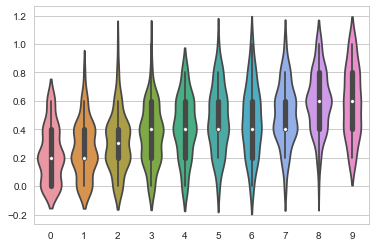

In [15]:
sns.set(style="whitegrid")
sns.violinplot(data = estimates)

From this chart you can see the considerable variation in the estimated values of $p_k$.

## Exploitation Algorithm

As a next step, let's try a simple exploitation algorithm. In the cell below, a function to find a policy is defined. The values of $p_k$ are estimated based on 5 pulls of each lever. Policy is determined by choosing the lever with the maximum $p_k$. **Ties are broken** by arbitrarily selecting the first lever in a list of possibilities. 

In [16]:
def find_max_lever(probabilities, pulls = 5):
    vals = pull_arms(probabilities, pulls)
    p = np.mean(vals, axis = 0)
    max_p = np.max(p)
    return np.where(p == max_p)[0][0]

nr.seed(654)
max_bandit = find_max_lever(probabilities)
max_bandit

3

We have found the *optimal policy* from the limited sample. The code in the cell below defines a function which simulates 1,000 pulls of the lever determined to be optimal. The average accumulated reward for each time step is computed by dividing the cumulative sum of rewards by the number of time steps. 

In [17]:
def exploit(n_samps, p): 
    samples = []
    for _ in range(n_samps):
        samples.append(nr.binomial(n = 1, p = p, size = 1))
    samples =  np.cumsum(np.concatenate(samples).ravel()) 
    n_samples = range(1, n_samps + 1)
    proportion = [s/float(i+1) for i,s in zip(range(n_samps), samples)]
    proportion[0] = 0.0
    
    return proportion

prob_success = exploit(1000, probabilities[max_bandit]) 

Execute the code in the cell below to plot the average reward accumulated at each time step.  

Text(0,0.5,'Aerage reward')

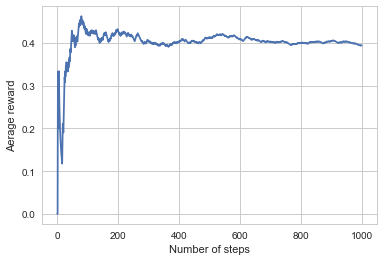

In [18]:
plt.plot(prob_success)
plt.xlabel('Number of steps')
plt.ylabel('Aerage reward')

As you might expect, the average reward for this exploiting approach converges to the value of $p_k$ for the lever chosen for the policy. 

## Exploring Algorithm

The function defined in the cell below implements a simple exploring algorithm. Policy is improve as the algorithm proceeds through the time steps. The algorithm works as follows:    
1. The algorithm loops over a number of **episodes**. The mean of the accumulated rewards is computed over the results of each episode. 
2. Within each episode an initial random policy is selected.
3. An inner loop iterates over the number of time steps of samples in each episode
4. With probability $\epsilon$ a random exploration step is taken. If the policy can be improved the new policy is adopted. 
5. The average accumulated rewards are computed. To limit memory use, the following commonly used update  expression is applied:   
$$NewEstimate \leftarrow OldEstimate + StepSize * \big[Target - OldEstimate \big]\\
where\ the\ error\ term\ is\\
\big[Target - OldEstimate \big]$$

Specific details of this code can be learned by reading the comments. 

Execute the code for 100 episodes of 10,000 samples using $\epsilon = 0.01$. The execution may take some time 

In [19]:
def e_greedy(n_samps, episodes, epsilon, probabilities):
    ## Array to keep the results for each step in each episode
    proportion = np.zeros((episodes, n_samps))
    n_probs = len(probabilities)
    
    for i in range(episodes):
        ## Lists to maintain values of q, n by index k = lever identifier
        q_n_k = np.zeros((2, n_probs))
        
        ## First randomly select a lever to pull
        k_best = nr.randint(0,(n_probs-1))
        p_best = probabilities[k_best]
        
        ## List for results by step
        q_values = []
        
        for j in range(n_samps):
            if(nr.uniform() <= epsilon): #Time to explore!
                ## First randomly select a lever to pull
                k_test = nr.randint(0,n_probs)
                p_test = probabilities[k_test]
                ## Pull the lever
                r_n = nr.binomial(n = 1, p = p_test, size = 1)
                ## Update the count
                q_n_k[1,k_test] = q_n_k[1,k_test] + 1
                ## Update Q
                q_n_k[0,k_test]  = q_n_k[0,k_test] + (r_n - q_n_k[0,k_test])/q_n_k[1,k_test]
                
                ## Is the new Q better than the old.
                ## If so, start using this level
                if(q_n_k[0,k_test] > q_n_k[0,k_best]):
                    k_best = k_test
                    p_best = p_test
                    
            ## Exploit wth best lever
            ## Pull the lever
            r_n = nr.binomial(n = 1, p = p_best, size = 1)
            ## Update the count
            q_n_k[1,k_best] = q_n_k[1,k_best] + 1
            ## Update Q
            q_n_k[0,k_best]  = q_n_k[0,k_best] + (r_n - q_n_k[0,k_best])/q_n_k[1,k_best]
            ## Append the Q value
            q_values.append(q_n_k[0,k_best])    
                
        ## At the end of the episode save the Q values
        proportion[i,:] = np.array(q_values).reshape((1, n_samps))
                
    return np.mean(proportion, axis = 0)

nr.seed(7878)
prob_success = e_greedy(10000, episodes = 100, epsilon = 0.01, probabilities = probabilities)

Execute the code in the cell below to display a plot of the average reward by time step. 

Text(0,0.5,'Aerage reward')

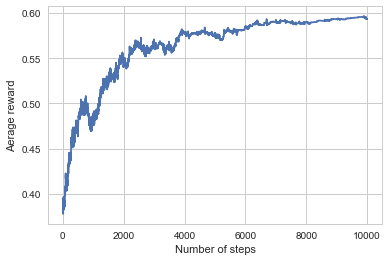

In [20]:
plt.plot(prob_success)
plt.xlabel('Number of steps')
plt.ylabel('Aerage reward')

The average reward slowly converges to the value of $p_k$ for the best lever. The policy is clearly being improved. 

Next, let's try another value of the exploitation-exploration trade-off parameter, $\epsilon = 0.1$. In this case, every tenth step will be exploratory, whereas for the first example every 100th step was exploratory. The question is, how does this change performance of the algorithm?

Text(0,0.5,'Aerage reward')

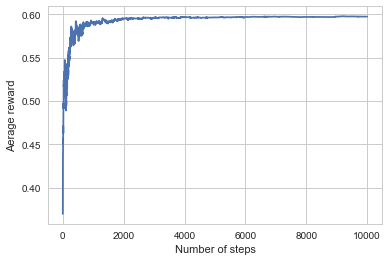

In [21]:
nr.seed(7879)
prob_success = e_greedy(10000, episodes = 100, epsilon = 0.1, probabilities = probabilities)

plt.plot(prob_success)
plt.xlabel('Number of steps')
plt.ylabel('Aerage reward')                        

With  $\epsilon = 0.1$ convergence is much faster. However, on average one out of ten steps requires the extra work of exploration. In this case, the trade-off seems well worth it, since convergence appears to occur in about half as many time steps. 

Finally, it is worth checking how this algorithm behaves with  $\epsilon = 0.0$, the pure exploitation case. 

Text(0,0.5,'Aerage reward')

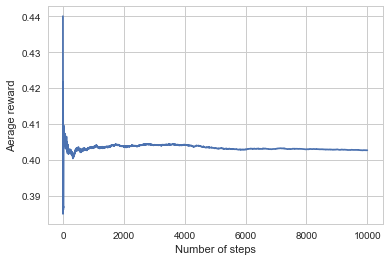

In [22]:
nr.seed(7880)
prob_success = e_greedy(10000, episodes = 100, epsilon = 0.0, probabilities = probabilities)

plt.plot(prob_success)
plt.xlabel('Number of steps')
plt.ylabel('Aerage reward')                        

As expected, the result is a sub-optimal policy. Further, this policy cannot improve, since there is no exploration of alternatives. 

#### Copyright 2018, Stephen F. Elston All rights reserved.